In [2]:
import os

path = "/home/marta/Documenti/eeg-ml-thesis/"
os.chdir(path)

import torch 
torch.set_num_threads(4) 

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import r_pca 
import scipy.io
from tqdm import tqdm
import datetime 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
import pandas as pd 
import csv

In [7]:
def pca_reduction(A, tol, comp = 0):
  rpca = False
  rpca_mu = 0
  multiscale_pca = False

  assert(len(A.shape) == 2)
  dmin = min(A.shape)
  if rpca:
    r = r_pca.R_pca(A, mu = rpca_mu)
    print('Auto tol:', 1e-7 * r.frobenius_norm(r.D), 'used tol:', tol)
    print('mu', r.mu, 'lambda', r.lmbda)
    L, S = r.fit(tol = tol, max_iter = 10, iter_print = 1)
    global norm_s
    norm_s = np.linalg.norm(S, ord='fro')  # for debug
    print('||A,L,S||:', np.linalg.norm(A, ord='fro'), np.linalg.norm(L, ord='fro'), np.linalg.norm(S, ord='fro'))
    #np.savez_compressed('rpca.npz', pre = A, post = L)
  elif multiscale_pca:
    print('MSPCA...')
    #ms = mspca.MultiscalePCA()
    #L = ms.fit_transform(A, wavelet_func='sym4', threshold=0.1, scale = True )
    print('saving MAT file and calling Matlab...')
    scipy.io.savemat('mspca.mat', {'A': A}, do_compression = True)
    os.system('matlab -batch "mspca(\'mspca.mat\')"')
    L = scipy.io.loadmat('mspca.mat')['L'] 
  else:
    
    L = A
  U, lam, V = np.linalg.svd(L, full_matrices = False)  # V is transposed
  assert(U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1]))
  #np.savetxt('singular_values.csv', lam)
  lam_trunc = lam[lam > 0.015 * lam[0]]  # magic number
  p = comp if comp else len(lam_trunc)
  assert(p <= dmin)
  print('PCA truncation', dmin, '->', p)
  return L, V.T[:,:p]


def precompute_crops(subject_list, 
                     window, 
                     overlap, 
                     DATASET_DIR, 
                     save_dir, 
                     csv_file_name,
                     task):

    base_dir = "/home/marta/Documenti/eeg-ml-thesis/"


    
    os.makedirs(save_dir, exist_ok=True)

    task_class = class_groups[task]
    label_mapping = {cls: i for i, cls in enumerate(task_class)}

    print(f"Class Mapping: {label_mapping}")
    mapping_file = os.path.join(base_dir, "output-milt", f"class_mapping_{task}.txt")

    with open(mapping_file, "w") as f:
        f.write(f"Task: {task}\n")
        f.write(f"Class mapping: {label_mapping}\n")

    
    all_crops = []

    for subject_id, category_label in subject_list:
        file_path = f"{DATASET_DIR}/{category_label}/{subject_id}.npy"

        eeg = np.load(file_path).T
        scaler = StandardScaler()
        eeg = scaler.fit_transform(eeg)

        num_columns = eeg.shape[1]
        num_windows = (len(eeg) - window) // (window - overlap) + 1

        i = 0
        for w in range(num_windows):
            x_data = eeg[i:i + window]
            i += (window - overlap)

            crop_filename = f"{subject_id}_{category_label}_crop{w}.npz"
            crop_save_path = os.path.join(save_dir, crop_filename)

            y_label = label_mapping[category_label]
            y_data = np.array([[y_label]])

            np.savez(crop_save_path, x_data=x_data, y_data=y_data)

            all_crops.append((subject_id, w, category_label,y_label, crop_save_path))

    train_ind, val_ind = train_test_split(all_crops, train_size=0.75, random_state=42, shuffle=True)

    with open(csv_file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["subject", "crops_number", "category_label", "label", "split", "file_path"])

        for crop in train_ind:
            writer.writerow([crop[0], crop[1], crop[2], crop[3], "train", crop[4]])
        for crop in val_ind:
            writer.writerow([crop[0], crop[1], crop[2], crop[3], "val", crop[4]])

def reduce_matrix(A, V, PCA_COMPONENTS):
    # Check the shape of A
    if len(A.shape) == 2:
        # If A is 2D (w, 16), expand it to (1, w, 16)
        A = np.expand_dims(A, axis=0)

    # Now A should be 3D: (N, w, 16)
    B = np.swapaxes(A, 1, 2)  # Swap axes: (N, 16, w)
    C = B.reshape((-1, B.shape[2]))  # Flatten: ((N*16), w)

    if V is None:
        L, V = pca_reduction(C, 5e-6, comp=PCA_COMPONENTS)

    B = C @ V  # Apply PCA: ((N*16), p)
    B = B.reshape((A.shape[0], A.shape[2], B.shape[1]))  # Reshape: (N, 16, p)

    return np.swapaxes(B, 1, 2), V  # Return: (N, p, 16)


def compute_and_save_pca_dataset(csv_file, output_dir, PCA_COMPONENTS):

    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    data_info = pd.read_csv(csv_file)

    # Select a random subset of the training data
    train_rows = data_info[data_info["split"] == "train"]
    sampled_train_rows = train_rows.sample(frac=0.2, random_state=42)  # Sample randomly

    train_data = []
    
    print(f"Processing training data for PCA computation on {len(sampled_train_rows)} samples...")
    for _, row in tqdm(sampled_train_rows.iterrows(), 
                       total=len(sampled_train_rows), 
                       desc="Sampling Training Data"):
        npz_data = np.load(row["file_path"])
        x_data = npz_data["x_data"]

        if len(x_data.shape) == 2:  
            x_data = np.expand_dims(x_data, axis=0)  # Convert (w, 16) → (1, w, 16)

        x_data = np.swapaxes(x_data, 1, 2)  # (N, 16, w) → (N, w, 16)
        x_data = x_data.reshape((-1, x_data.shape[2]))  # ((N*16), w)

        train_data.append(x_data)

    train_data = np.vstack(train_data)  # Stack sampled data
    _, Vpca = pca_reduction(train_data, tol=5e-6, comp=PCA_COMPONENTS)

    print(f"Computed PCA matrix (Vpca) with shape: {Vpca.shape}")

    return Vpca

def apply_pca_to_dataset(csv_file, output_dir, Vpca, PCA_COMPONENTS):
    
    os.makedirs(output_dir, exist_ok=True)  

    data_info = pd.read_csv(csv_file)

    for _, row in tqdm(data_info.iterrows(), total=len(data_info), desc="Transforming Data"):
        npz_data = np.load(row["file_path"])
        x_data = npz_data["x_data"]
        y_data = npz_data["y_data"]

        x_data, _ = reduce_matrix(x_data, Vpca, PCA_COMPONENTS)  

        save_path = os.path.join(output_dir, os.path.basename(row["file_path"]))
        np.savez(save_path, x_data=x_data, y_data=y_data)
        # print(f"Saved PCA-transformed test file: {save_path}")

def subj_list_task(task, df):
    """Creates list of subjects to load based on the task"""

    subset = df[df["Group"].isin(class_groups[task])]

    subject_list = tuple(zip(subset['participant_id'], subset['Group']))

    train, test = train_test_split(subject_list, test_size = 0.1, random_state=42, stratify=subset["Group"])

    print(f"Task: {task}")
    print(f"Number of Subjects in Train set {len(train)}")
    print(f"Number of Subjects in Train set {len(test)}")

    return train, test

In [11]:
DATASET_DIR = "/home/marta/Documenti/milt_np_dataset"
OUTPUT_DATA_DIR = "/home/marta/Documenti/data-milt-preprocessed/"
os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)
WINDOW = 1000
OVERLAP = WINDOW // 4
TASK = "A_vs_C"
# OVERLAP = 0
PCA_COMPONENTS = 50
num_epochs = 20
print(f"window: {WINDOW}")
print(f"overlap: {OVERLAP}")
print(f"number pca components: {PCA_COMPONENTS}")

## CLASSES
# A	"Alzheimer Disease Group"
# F	"Frontotemporal Dementia Group"
# C	"Healthy Group"

# Loading data and computing crops
df = pd.read_csv("/home/marta/Documenti/milt_dataset/datatset/participants.tsv",sep="\t")

class_groups = {
    "A_vs_C": ["A", "C"],
    "A_vs_F": ["A", "F"],
    "F_vs_C": ["F", "C"],
    "A_vs_F_vs_C": ["A", "F", "C"]
}
# function that creates the list of subjects to load based on the task
train_subj_list, test_subj_list = subj_list_task(TASK, df)

test_path = os.path.join(OUTPUT_DATA_DIR, f"test_w{WINDOW}_ovr{OVERLAP}_{TASK}")
train_path = os.path.join(OUTPUT_DATA_DIR, f"train_w{WINDOW}_ovr{OVERLAP}_{TASK}")
os.makedirs(test_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)


train_config = f"config/train_w{WINDOW}_ovr{OVERLAP}_{TASK}.csv"
test_config = f"config/test_w{WINDOW}_ovr{OVERLAP}_{TASK}.csv"

precompute_crops(train_subj_list, 
                 window=WINDOW, 
                 DATASET_DIR=DATASET_DIR, 
                 ave_dir=train_path,
                 csv_file_name= train_config, 
                 task=TASK, overlap=OVERLAP)

precompute_crops(test_subj_list, 
                 window=WINDOW, 
                 DATASET_DIR=DATASET_DIR, 
                 save_dir=test_path, 
                 csv_file_name= test_config,
                 task=TASK, overlap=OVERLAP)

window: 1000
overlap: 250
number pca components: 50
Task: A_vs_C
Number of Subjects in Train set 58
Number of Subjects in Train set 7
Class Mapping: {'A': 0, 'C': 1}
Class Mapping: {'A': 0, 'C': 1}


In [12]:
 
test_pca_path = os.path.join(OUTPUT_DATA_DIR, f"test_w{WINDOW}_ovr{OVERLAP}_pca{PCA_COMPONENTS}_{TASK}")
train_pca_path = os.path.join(OUTPUT_DATA_DIR, f"train_w{WINDOW}_ovr{OVERLAP}_pca{PCA_COMPONENTS}_{TASK}")
os.makedirs(test_pca_path, exist_ok=True)
os.makedirs(train_pca_path, exist_ok=True)



Vpca = compute_and_save_pca_dataset(train_config, train_pca_path, PCA_COMPONENTS=50)


apply_pca_to_dataset(test_config, test_pca_path, Vpca, PCA_COMPONENTS=50)
apply_pca_to_dataset(train_config, train_pca_path, Vpca, PCA_COMPONENTS=50)


Processing training data for PCA computation on 4726 samples...


Sampling Training Data: 100%|██████████| 4726/4726 [01:02<00:00, 75.74it/s] 


PCA truncation 1000 -> 50
Computed PCA matrix (Vpca) with shape: (1000, 50)


Transforming Data: 100%|██████████| 31508/31508 [38:48<00:00, 13.53it/s]  


In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

def pca_reduction(A, tol, comp=0):
    rpca = False
    rpca_mu = 0
    multiscale_pca = False

    assert(len(A.shape) == 2)
    dmin = min(A.shape)

    if rpca:
        r = r_pca.R_pca(A, mu=rpca_mu)
        print('Auto tol:', 1e-7 * r.frobenius_norm(r.D), 'used tol:', tol)
        print('mu', r.mu, 'lambda', r.lmbda)
        L, S = r.fit(tol=tol, max_iter=10, iter_print=1)
        global norm_s
        norm_s = np.linalg.norm(S, ord='fro')
        print('||A,L,S||:', np.linalg.norm(A, ord='fro'), np.linalg.norm(L, ord='fro'), np.linalg.norm(S, ord='fro'))
    elif multiscale_pca:
        print('MSPCA...')
        scipy.io.savemat('mspca.mat', {'A': A}, do_compression=True)
        os.system('matlab -batch "mspca(\'mspca.mat\')"')
        L = scipy.io.loadmat('mspca.mat')['L']
    else:
        L = A
    
    U, lam, V = np.linalg.svd(L, full_matrices=False)
    assert U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1])
    
    lam_trunc = lam[lam > 0.015 * lam[0]]
    p = comp if comp else len(lam_trunc)
    assert p <= dmin
    print('PCA truncation', dmin, '->', p)
    
    explained_variance = (lam ** 2) / np.sum(lam ** 2)
    
    return L, V.T[:, :p], explained_variance[:p]

def reduce_matrix(A, V, PCA_COMPONENTS):
    if len(A.shape) == 2:
        A = np.expand_dims(A, axis=0)

    B = np.swapaxes(A, 1, 2)
    C = B.reshape((-1, B.shape[2]))

    if V is None:
        _, V, _ = pca_reduction(C, 5e-6, comp=PCA_COMPONENTS)

    B = C @ V
    B = B.reshape((A.shape[0], A.shape[2], B.shape[1]))
    
    return np.swapaxes(B, 1, 2), V

def compute_vpca(csv_file, output_dir, PCA_COMPONENTS):
    os.makedirs(output_dir, exist_ok=True)
    data_info = pd.read_csv(csv_file)

    train_rows = data_info[data_info["split"] == "train"]
    sampled_train_rows = train_rows.sample(frac=0.2, random_state=42)

    train_data = []
    
    print(f"Processing training data for PCA computation on {len(sampled_train_rows)}")
    for _, row in tqdm(sampled_train_rows.iterrows(), total=len(sampled_train_rows), desc="Sampling Training Data"):
        npz_data = np.load(row["file_path"])
        x_data = npz_data["x_data"]

        if len(x_data.shape) == 2:
            x_data = np.expand_dims(x_data, axis=0)

        x_data = np.swapaxes(x_data, 1, 2)
        x_data = x_data.reshape((-1, x_data.shape[2]))
        train_data.append(x_data)

    train_data = np.vstack(train_data)
    _, Vpca, explained_variance = pca_reduction(train_data, tol=5e-6, comp=PCA_COMPONENTS)

    print(f"Computed PCA matrix (Vpca) with shape: {Vpca.shape}")
    
    variance_plot_path = os.path.join(output_dir, "explained_variance.png")
    plt.figure()
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance vs. Number of Components")
    plt.grid()
    plt.savefig(variance_plot_path)
    plt.show()
    plt.close()
    
    print(f"Saved explained variance plot at: {variance_plot_path}")
    
    return Vpca

def apply_pca_to_dataset(csv_file, output_dir, Vpca, PCA_COMPONENTS):
    os.makedirs(output_dir, exist_ok=True)
    data_info = pd.read_csv(csv_file)

    for _, row in tqdm(data_info.iterrows(), total=len(data_info), desc="Transforming Data"):
        npz_data = np.load(row["file_path"])
        x_data = npz_data["x_data"]
        y_data = npz_data["y_data"]

        x_data, _ = reduce_matrix(x_data, Vpca, PCA_COMPONENTS)

        save_path = os.path.join(output_dir, os.path.basename(row["file_path"]))
        np.savez(save_path, x_data=x_data, y_data=y_data)
    
    print("PCA transformation complete.")


In [12]:
os.getcwd()

'/home/marta/Documenti/eeg-ml-thesis'

In [5]:
import seaborn as sns 

In [6]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,         # Enable grid
    "grid.color": "gray",  # Set grid color to light gray
    "grid.linestyle": "--",     # Set grid line style to dashed
    "grid.linewidth": 0.5,      # Set grid line width
    "figure.facecolor": "#fbfbfb",
    "axes.facecolor": "#fbfbfb",
    "axes.labelsize": 12,  # Increase label size
    "xtick.labelsize": 10,  # Increase tick size
    "ytick.labelsize": 10,  # Increase tick size
    "legend.fontsize": 10   # Improve legend readability
}

sns.set_theme(style="ticks", rc=custom_params)

Processing training data for PCA computation on 4726


Sampling Training Data:   0%|          | 0/4726 [00:00<?, ?it/s]

Sampling Training Data: 100%|██████████| 4726/4726 [00:03<00:00, 1253.91it/s]


PCA truncation 1000 -> 60
Computed PCA matrix (Vpca) with shape: (1000, 60)


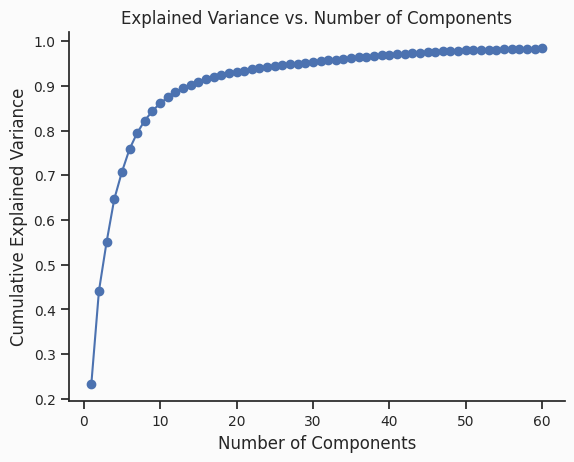

Saved explained variance plot at: /home/marta/Documenti/eeg-ml-thesis/data_analysis/explained_variance.png


In [8]:
csv_file = "path/to/your/dataset.csv"  # Path to your dataset CSV
output_dir = '/home/marta/Documenti/eeg-ml-thesis/data_analysis' # Directory to save the explained variance plot and PCA matrix
PCA_COMPONENTS = 60  # Adjust the number of components as needed
WINDOW = 1000
PERCENTAGE_OVERLAP = 4
OVERLAP = WINDOW // PERCENTAGE_OVERLAP
TASK = "A_vs_C"


csv_file = f"config/train_w{WINDOW}_ovr{OVERLAP}_{TASK}.csv"
#train_pca_path = os.path.join(OUTPUT_DATA_DIR, f"train_w{WINDOW}_ovr{OVERLAP}_pca{PCA_COMPONENTS}_{TASK}")

Vpca = compute_vpca(csv_file, output_dir, PCA_COMPONENTS)
